In [5]:
import pandas as pd
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import os
filepath = os.getcwd()

def perform_elbow_analysis(file_path, max_clusters=10, sep=';'):
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    inertia = []
    for k in range(1, max_clusters + 1):
        model = TimeSeriesKMeans(n_clusters=k, metric="euclidean", verbose=False)
        model.fit(ts_scaled)
        inertia.append(model.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method for Determining Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()


def fit_model_and_visualize_clusters(file_path, n_clusters, sep=';'):
    # Load and preprocess data
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    # Fit the model
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True)
    y_pred = model.fit_predict(ts_scaled)

    # Visualize clusters
    plt.figure(figsize=(12, 8))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)
        for xx in ts_scaled[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=0.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.title(f"Cluster {yi + 1}")
        plt.xlim([0, max_length])
    plt.tight_layout()
    plt.show()

    return model, scaler



def predict_cluster(consumption_file, model, scaler):
    # Reshape the timeseries_sample
    data = pd.read_csv(consumption_file, index_col=0, sep=';')
    data = data.sample(1)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)
    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))
    ts_data = to_time_series_dataset(list(uniform_series))
    ts_scaled = scaler.fit_transform(ts_data)
    cluster = model.predict(ts_scaled)
    return cluster









Elbow analysis for 1 year of consumption data


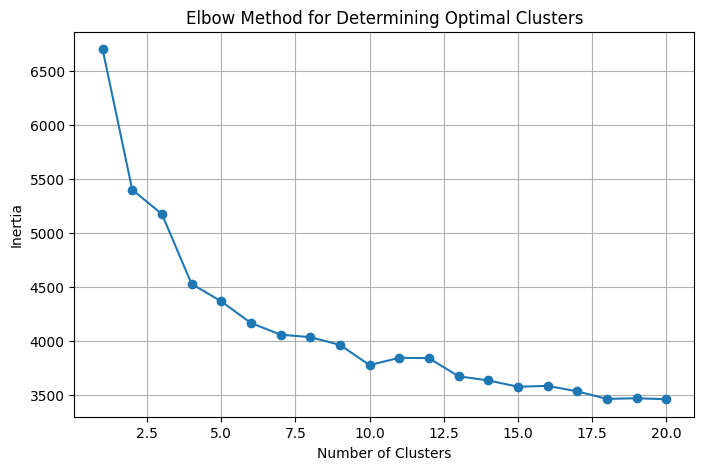

Elbow analysis for 3 years of consumption data


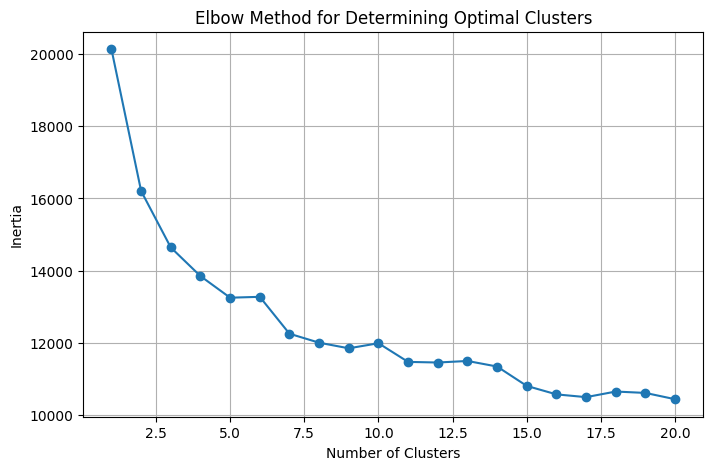

Elbow analysis for 1 year of production data


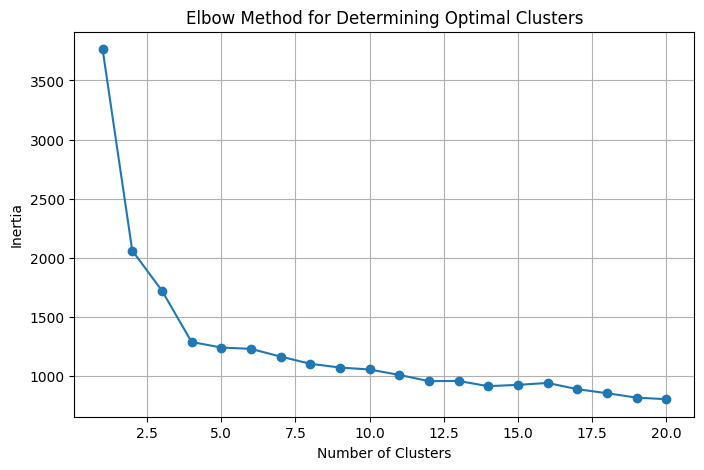

Elbow analysis for 3 years of production data


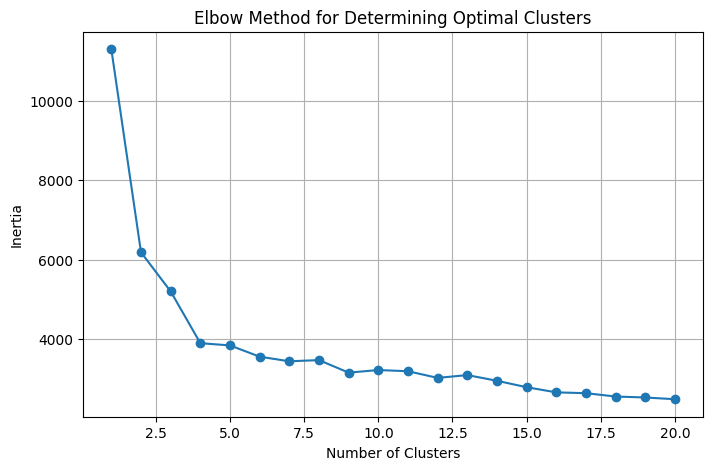

In [6]:
# Determine optimal clusters
consumption1y = filepath+"/dataset/consumption-1y-processed.csv"
print("Elbow analysis for 1 year of consumption data")
perform_elbow_analysis(consumption1y, max_clusters=20)

consumption3y = filepath+"/dataset/consumption-3y-processed.csv"
print("Elbow analysis for 3 years of consumption data")
perform_elbow_analysis(consumption3y, max_clusters=20)

production1y = filepath+"/dataset/production-1y-processed.csv"
print("Elbow analysis for 1 year of production data")
perform_elbow_analysis(production1y, max_clusters=20)

production3y = filepath+"/dataset/production-3y-processed.csv"
print("Elbow analysis for 3 years of production data")
perform_elbow_analysis(production3y, max_clusters=20)




4846.704 --> 3985.428 --> 3948.811 --> 3943.093 --> 3941.776 --> 3940.532 --> 3939.795 --> 3939.795 --> 


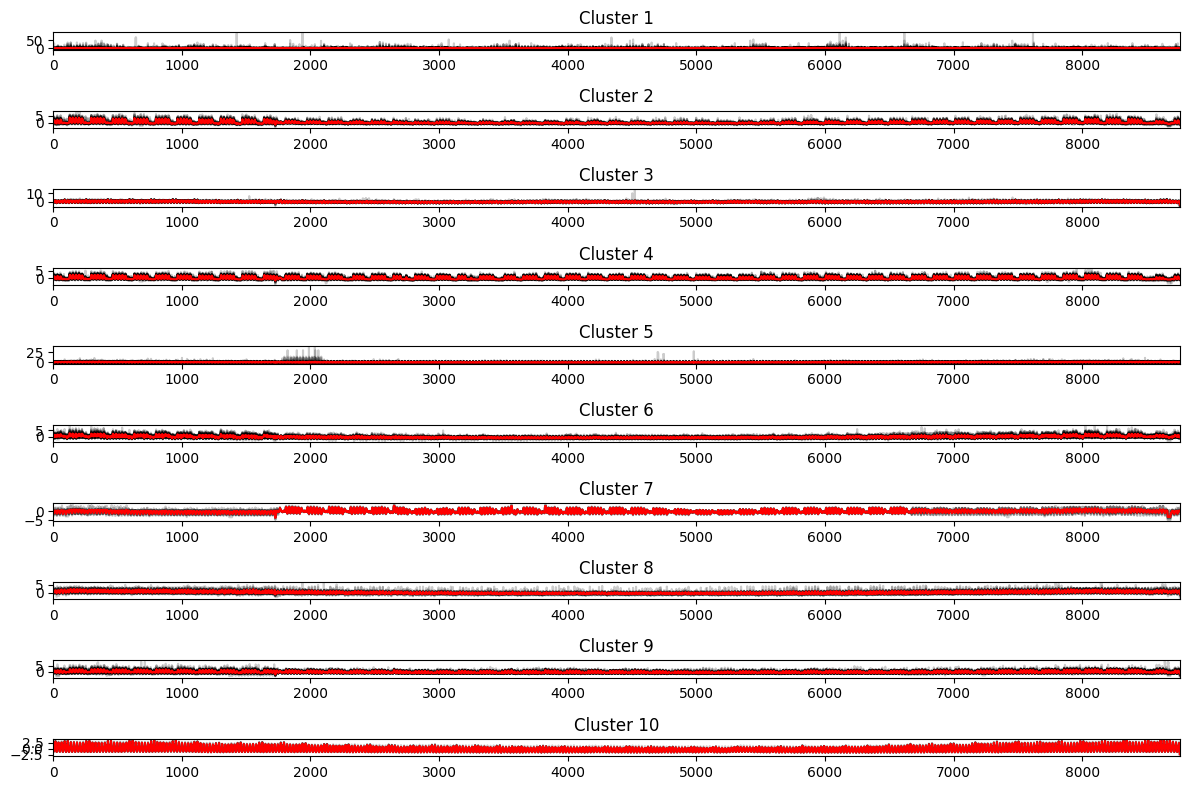

15195.826 --> 12325.261 --> 12088.609 --> 12008.260 --> 11926.742 --> 11862.598 --> 11845.079 --> 11840.967 --> 11837.128 --> 11837.128 --> 


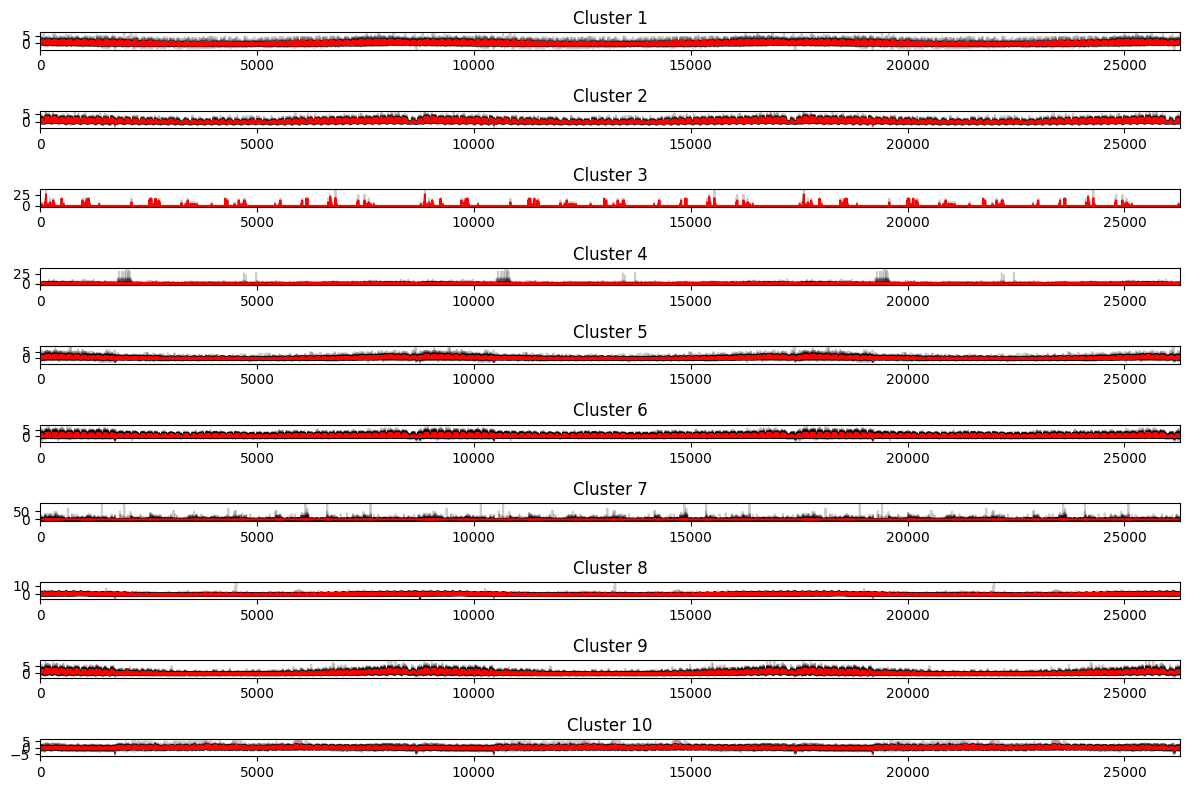

1352.107 --> 1067.023 --> 1059.815 --> 1057.544 --> 1056.515 --> 1056.069 --> 1055.789 --> 1055.789 --> 


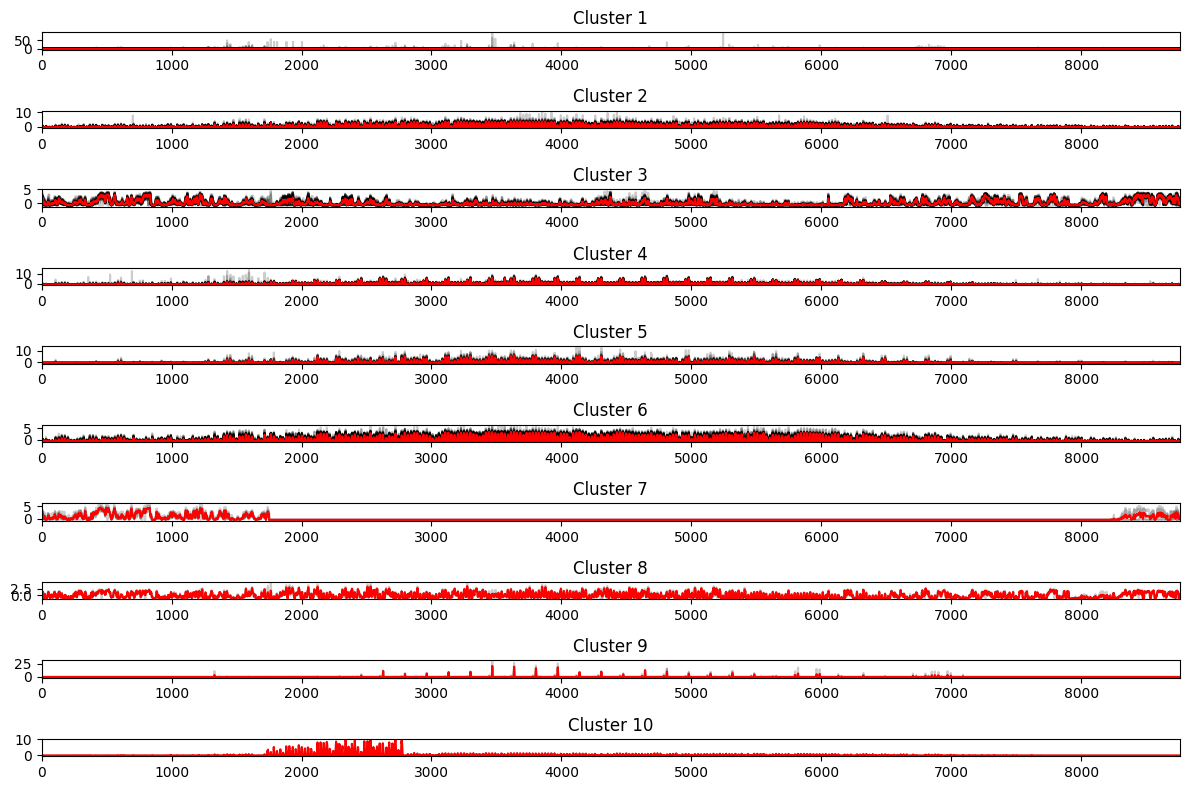

3991.844 --> 3200.895 --> 3173.964 --> 3170.226 --> 3169.056 --> 3169.056 --> 


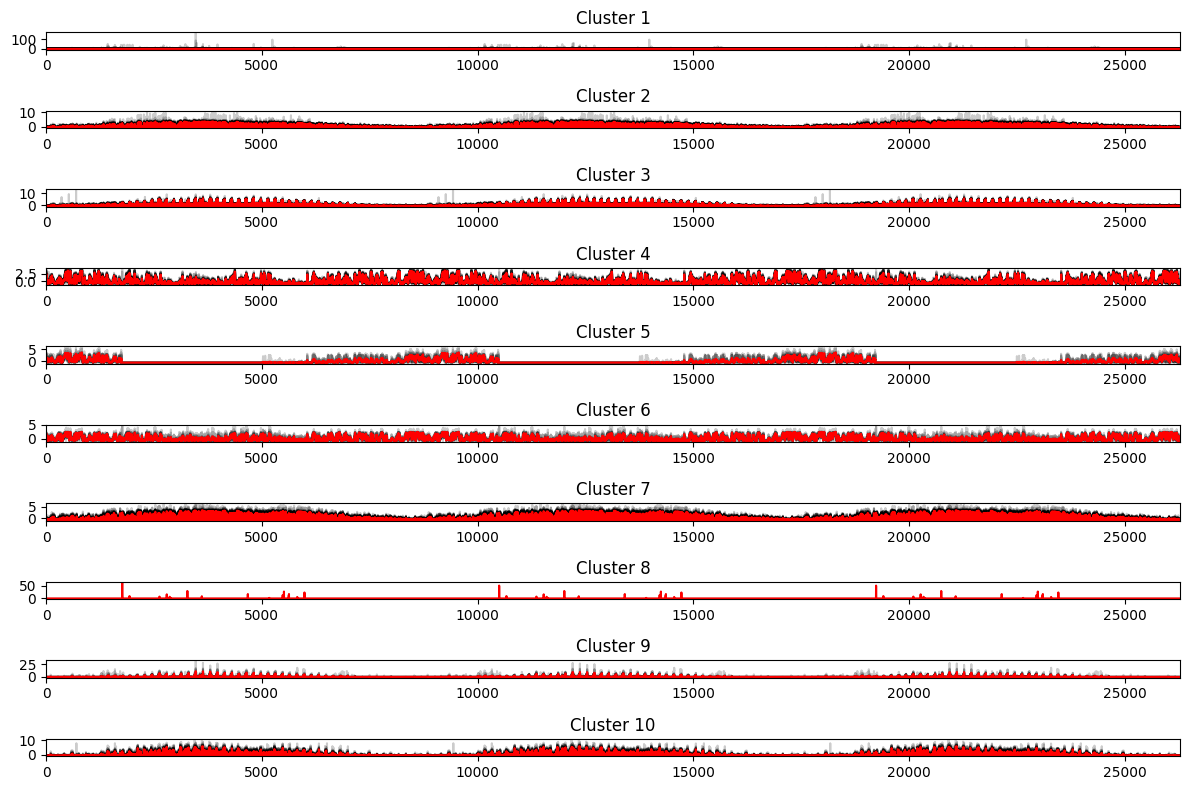

In [7]:
#Fit all the models using 10 clusters
model_consumption1y, scaler_consumption1y = fit_model_and_visualize_clusters(consumption1y, 10)
model_consumption3y, scaler_consumption3y = fit_model_and_visualize_clusters(consumption3y, 10)
model_production1y, scaler_production1y = fit_model_and_visualize_clusters(production1y, 10)
model_production3y, scaler_production3y = fit_model_and_visualize_clusters(production3y, 10)



In [8]:
# Calculate the silhouette score



In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw, dtw_path
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

def fit_model_and_identify_representatives(file_path, n_clusters, sep=';'):
    # Load and preprocess data
    data = pd.read_csv(file_path, index_col=0, sep=sep)
    data_reset = data.reset_index()
    long_df = data_reset.melt(id_vars=['Id'], var_name='Time', value_name='Value')
    long_df.sort_values(by=['Id', 'Time'], inplace=True)

    grouped = long_df.groupby('Id')['Value'].apply(list)
    max_length = grouped.apply(len).max()
    uniform_series = grouped.apply(lambda x: x + [np.nan] * (max_length - len(x)))

    ts_data = to_time_series_dataset(list(uniform_series))
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    ts_scaled = scaler.fit_transform(ts_data)

    # Fit the model
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True)
    y_pred = model.fit_predict(ts_scaled)

    # Find representative time series and their Ids
    representatives = []
    representative_ids = []
    for k in range(n_clusters):
        cluster_center = model.cluster_centers_[k]
        # Calculate distances within the cluster
        distances = cdist_dtw(ts_scaled[y_pred == k], cluster_center.reshape(1, -1, 1))
        # Get the index of the minimum distance
        representative_idx = np.argmin(distances)
        representatives.append(ts_data[y_pred == k][representative_idx])
        representative_ids.append(data_reset['Id'][y_pred == k].iloc[representative_idx])

    # Visualize clusters
    plt.figure(figsize=(12, 8))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, yi + 1)
        for xx in ts_scaled[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=0.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.title(f"Cluster {yi + 1}")
        plt.xlim([0, max_length])
    plt.tight_layout()
    plt.show()

    return model, scaler, representatives, representative_ids


5222.037 --> 4045.342 --> 3966.091 --> 3892.919 --> 3872.781 --> 3857.387 --> 3841.352 --> 3831.204 --> 3829.448 --> 3826.313 --> 3825.700 --> 3825.243 --> 3824.246 --> 3824.246 --> 


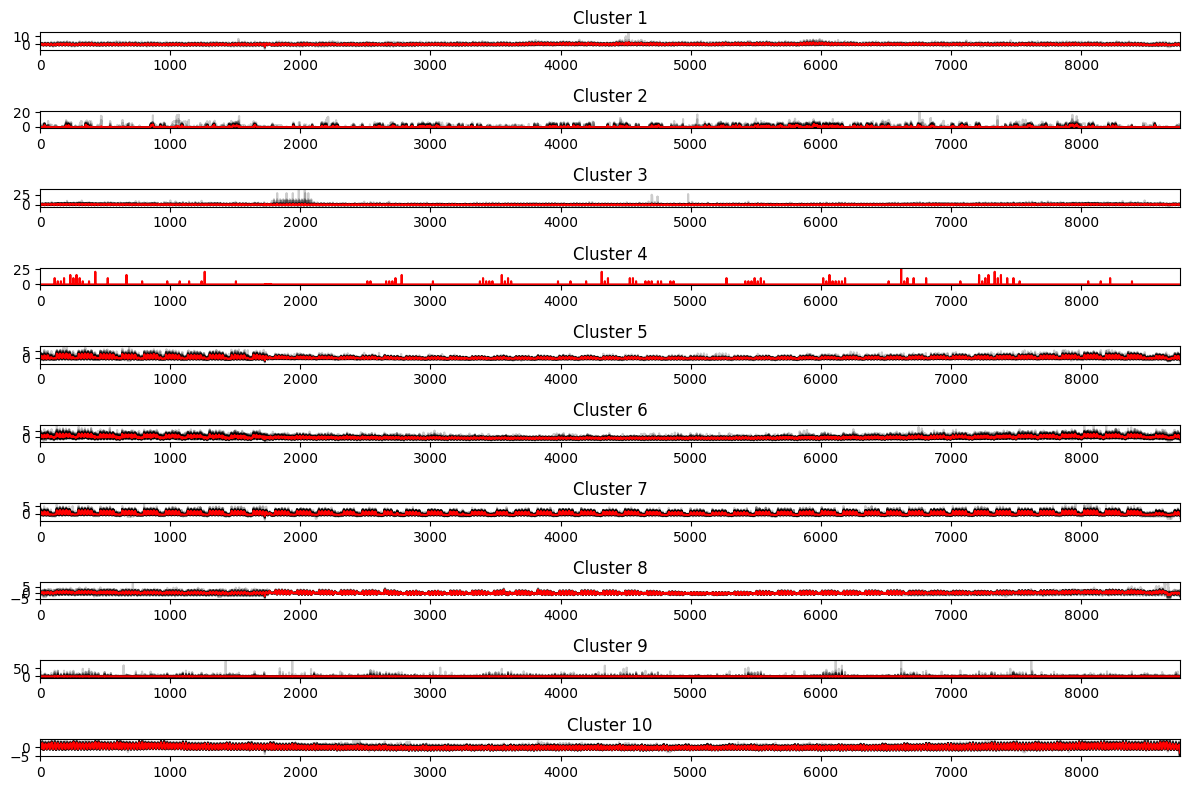

15753.694 --> 12086.602 --> 11728.753 --> 11611.418 --> 11600.622 --> 11584.788 --> 11582.081 --> 11582.081 --> 


In [10]:
n_clusters = 10
model_consumption1y, scaler_consumption1y, representatives_consumption1y, representative_ids_consumption1y = fit_model_and_identify_representatives(consumption1y, n_clusters)
model_consumption3y, scaler_consumption3y, representatives_consumption3y, representative_ids_consumption3y = fit_model_and_identify_representatives(consumption3y, n_clusters)
model_production1y, scaler_production1y, representatives_production1y, representative_ids_production1y = fit_model_and_identify_representatives(production1y, n_clusters)
model_production3y, scaler_production3y, representatives_production3y, representative_ids_production3y = fit_model_and_identify_representatives(production3y, n_clusters)

for idx, ts in enumerate(representatives_consumption1y):
    print(f"Representative time series for Cluster {idx + 1}: {ts.ravel()}")

for idx, ts in enumerate(representatives_consumption3y):
    print(f"Representative time series for Cluster {idx + 1}: {ts.ravel()}")

for idx, ts in enumerate(representatives_production1y):
    print(f"Representative time series for Cluster {idx + 1}: {ts.ravel()}")

for idx, ts in enumerate(representatives_production3y):
    print(f"Representative time series for Cluster {idx + 1}: {ts.ravel()}")



In [ ]:
#save models to pickle
import pickle
import pandas as pd

# Save models and scalers to pickle
with open('model_consumption1y.pkl', 'wb') as f:
    pickle.dump(model_consumption1y, f)
with open('scaler_consumption1y.pkl', 'wb') as f:
    pickle.dump(scaler_consumption1y, f)

with open('model_consumption3y.pkl', 'wb') as f:
    pickle.dump(model_consumption3y, f)
with open('scaler_consumption3y.pkl', 'wb') as f:
    pickle.dump(scaler_consumption3y, f)

with open('model_production1y.pkl', 'wb') as f:
    pickle.dump(model_production1y, f)
with open('scaler_production1y.pkl', 'wb') as f:
    pickle.dump(scaler_production1y, f)

with open('model_production3y.pkl', 'wb') as f:
    pickle.dump(model_production3y, f)
with open('scaler_production3y.pkl', 'wb') as f:
    pickle.dump(scaler_production3y, f)

# Save representatives and representative_ids to pandas DataFrame
representatives_df = pd.DataFrame({
    'representatives_consumption1y': representatives_consumption1y,
    'representative_ids_consumption1y': representative_ids_consumption1y,
    'representatives_consumption3y': representatives_consumption3y,
    'representative_ids_consumption3y': representative_ids_consumption3y,
    'representatives_production1y': representatives_production1y,
    'representative_ids_production1y': representative_ids_production1y,
    'representatives_production3y': representatives_production3y,
    'representative_ids_production3y': representative_ids_production3y
})

representatives_df.to_pickle('representatives_df.pkl')


In [ ]:
representatives

[array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 array([[3.7443647e-04],
        [3.7414350e-04],
        [3.8024687e-04],
        ...,
        [1.9524210e-04],
        [3.1324022e-04],
        [8.8636920e-05]]),
 array([[621.0337 ],
        [606.999  ],
        [588.5496 ],
        ...,
        [691.2645 ],
        [672.73615],
        [491.8268 ]]),
 array([[0.738418  ],
        [0.71070075],
        [0.65449876],
        ...,
        [0.6899291 ],
        [0.74065095],
        [0.18714266]]),
 array([[74.215   ],
        [57.83    ],
        [54.01    ],
        ...,
        [75.45    ],
        [75.395004],
        [73.15    ]]),
 array([[1.088935  ],
        [0.94321   ],
        [0.8048119 ],
        ...,
        [1.3764502 ],
        [1.271634  ],
        [0.30508634]]),
 array([[15.908],
        [15.562],
        [15.213],
        ...,
        [ 0.   ],
        [ 0.   ],
        [ 0.   ]]),
 array([[3.12],
        [3.12],
     